<a href="https://colab.research.google.com/github/andresRah/keepcoding-ia/blob/main/Andres_Arevalo_practica_IA_Keepcoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Práctica IA - Keepcoding**

#**Descripción del Proyecto:**

### **Desarrollar un chatbot como sistema de recomendación para los clientes del bar Harry Beer Station.**

El bar ofrece una amplia variedad de cervezas internacionales, y el chatbot permitirá a los usuarios indicar el país de origen de la cerveza que desean consumir. El sistema debe proporcionar especificaciones detalladas de la cerveza, posibles acompañamientos, y otra información relevante sobre la cerveza o cervezas en general, utilizando el ranking mundial consultado en internet. Además, los usuarios podrán consultar si una cerveza específica está disponible en el bar y, si no desean cerveza, el chatbot ofrecerá opciones de otros licores y cócteles.

### Requisitos Técnicos

**Fuentes de Datos (Toolbelt):**
     

1.   Inventario oficial de Harry Beer Station.
2.   Información de internet utilizando Duck Duck Go Web Search.
3.   Dataset de varias cervezas con su ranking mundial.
4.   Libro de recetas de cócteles.



        
        
        

### **Tareas:**

  **1) Data Preparation:**  
  Desarrollar un script para el inventario oficial que:
            Añada una columna "descripción" consultando descripciones breves en internet.
      Utilizar Duck Duck Go Web Search para obtener descripciones.

  **2) Document Loader y Chunker:**

  Cargar los datos del inventario, dataset de rankings y libro de recetas.
  Dividir los documentos en partes manejables para el procesamiento.

  **3) Embedding Vector DB:**

  Crear una base de datos de vectores de embeddings para almacenar y recuperar documentos.

  **4) Rerank y Augmented Prompt:**

  Implementar un sistema de rerank para organizar los resultados.
  Generar prompts aumentados para mejorar la precisión de las respuestas del LLM.

  **5) Desarrollo del Chatbot:**

  Integrar todas las fuentes de datos y componentes del modelo RAG.
  Asegurar que el chatbot pueda responder consultas sobre cervezas, su disponibilidad, información adicional y sugerencias de acompañamientos.
  Ofrecer alternativas de otros licores y cócteles cuando el usuario no desee consumir cerveza.

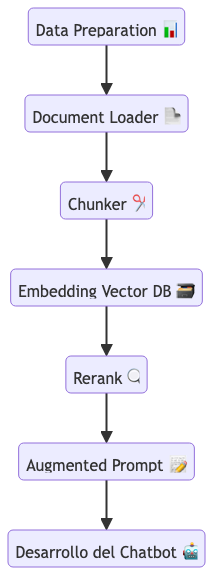

In [11]:
!pip install langchain pypdf duckduckgo_search openai langchain_experimental langchain_openai umap-learn langchain_community faiss-cpu tiktoken

In [12]:
!pip install langchain langchain_community duckduckgo_search pypdf openai langchain_experimental langchain_openai seaborn umap-learn matplotlib

## 1. Preparación de Datos

In [ ]:
#1. Preparación de Datos
import pandas as pd
from langchain_community.tools.ddg_search import DuckDuckGoSearchRun

# Cargar el inventario
inventario_df = pd.read_csv('/content/Inventario Harry Beer CSV.csv', delimiter=';')
inventario_df.head()

Categoria                            Item     Referencia  Cantidad  Estado  \
0   Cerveza          Czechvar Botella 330ml  8594403110128         0  Activo   
1   Cerveza       Liefmans Fruitesse 250 ml  5411686700118         4  Activo   
2   Cerveza                    Duvel 330 ml  5411681014005         0  Activo   
3   Cerveza  Maredsous Blonde Blond  330 ml  5411681035000         0  Activo   
4   Cerveza         Maredsous Brune  330 ml  5411681037004         0  Activo   

  Costo promedio    Total  
0        $18.961       $0  
1         $4.360  $17.439  
2         $9.814       $0  
3        $19.423       $0  
4        $10.189       $0

In [ ]:
import time
from langchain_community.tools.ddg_search import DuckDuckGoSearchRun

# Inicializar DuckDuckGoSearchRun
ddg_search = DuckDuckGoSearchRun()

# Función para obtener descripciones con manejo de límite de tasa
def obtener_descripcion(nombre):
    intentos = 3
    for intento in range(intentos):
        try:
            resultados = ddg_search.run(f"{nombre} description")
            if resultados:
              return resultados
        except Exception as e:
            if 'Ratelimit' in str(e):
                print(f"Rate limit alcanzado: {e}. Esperando 10 segundos antes de reintentar.")
                time.sleep(10)
            else:
                print(f"Error: {e}. Reintentando en 5 segundos.")
                time.sleep(5)
        print(f"Intento {intento + 1} de {intentos} fallido. Reintentando...")
    return "Descripción no encontrada."

# Añadir la columna "Descripcion" con pausas entre consultas
inventario_df['Descripcion'] = inventario_df['Item'].apply(obtener_descripcion)

# Guardar el inventario actualizado
inventario_df.to_csv('/content/Inventario_Harry_Beer_Actualizado.csv', index=False)

# Mostrar las primeras filas del inventario actualizado
print(inventario_df.head())

Rate limit alcanzado: https://links.duckduckgo.com/d.js?q=Sidra+Stowford+Press+500ml+description&kl=wt-wt&l=wt-wt&p=&s=0&df=y&vqd=4-154477635167417253150097274102936420420&bing_market=wt-WT&ex=-1 202 Ratelimit. Esperando 10 segundos antes de reintentar.
Intento 1 de 3 fallido. Reintentando...
Rate limit alcanzado: https://links.duckduckgo.com/d.js?q=Aguardiente+Antioque%C3%B1o+Azul+375ml+description&kl=wt-wt&l=wt-wt&p=&s=0&df=y&vqd=4-182415145206809460039679389417575703972&bing_market=wt-WT&ex=-1 202 Ratelimit. Esperando 10 segundos antes de reintentar.
Intento 1 de 3 fallido. Reintentando...
Rate limit alcanzado: https://links.duckduckgo.com/d.js?q=Whisky+Jack+Daniel%27s+Honey+750ml+description&kl=wt-wt&l=wt-wt&p=&s=0&df=y&vqd=4-251689571769241888662049989171877474620&bing_market=wt-WT&ex=-1 202 Ratelimit. Esperando 10 segundos antes de reintentar.
Intento 1 de 3 fallido. Reintentando...
  Categoria                            Item     Referencia  Cantidad  Estado  \
0   Cerveza       

In [ ]:
inventario_df.head(10)

Categoria                                     Item  \
0              Cerveza                   Czechvar Botella 330ml   
1              Cerveza                Liefmans Fruitesse 250 ml   
2              Cerveza                             Duvel 330 ml   
3              Cerveza           Maredsous Blonde Blond  330 ml   
4              Cerveza                  Maredsous Brune  330 ml   
5              Cerveza                 Maredsous Triple  330 ml   
6              Cerveza                   Vedett Extra IPA 330ml   
7              Cerveza                 Vedett Extra White 330ml   
8              Cerveza            Paulaner Dunkel Botella 500ml   
9  Cerveza sin alcohol  Paulaner Alkoholfrei  Sin Alcohol 500ml   

      Referencia  Cantidad  Estado Costo promedio    Total  \
0  8594403110128         0  Activo        $18.961       $0   
1  5411686700118         4  Activo         $4.360  $17.439   
2  5411681014005         0  Activo         $9.814       $0   
3  5411681035000         0  Activo        $19.423       $0   
4  5411681037004         0  Activo        $10.189       $0   
5  5411681038001         0  Activo         $7.809       $0   
6  5411681401775         0  Activo         $9.362       $0   
7  5411681400310         0  Activo         $4.418       $0   
8  4066600303336         3  Activo        $18.273  $54.819   
9  4066600612049         0  Activo         $4.288       $0   

                                         Descripcion  
0  Czechvar is the special name (editor's note: f...  
1  Liefmans Fruitesse On The Rocks is a Fruit and...  
2  The Duvel Experience. Drinking Duvel is not ju...  
3  Maredsous 6 Blond a Belgian Ale - Pale / Golde...  
4  Maredsous 8 - Brune is a Dubbel style beer bre...  
5  Maredsous 10 - Triple is a Tripel style beer b...  
6  mark is drinking a Vedett Extra Ordinary IPA (...  
7  The regular Vedett Extra White is sold in Chin...  
8  Hefe-Weissbier Dunkel is a Dunkelweizen style ...  
9  Paulaner USA, the U.S. importer of the renowne...

## 2. Cargador de Documentos (Document Loader)

In [13]:
from langchain.document_loaders import PyPDFLoader, TextLoader

# Cargar documentos
pdf_loader = PyPDFLoader('/content/101_cocktails_receipes.pdf')
beer_list_loader = TextLoader('/content/beer_list.csv')
inventario_loader = TextLoader('/content/Inventario_Harry_Beer_Actualizado.csv')

# Cargar las páginas del PDF
cocktails_docs = pdf_loader.load()
beer_list_docs = beer_list_loader.load()
inventario_docs = inventario_loader.load()

In [4]:
print(cocktails_docs[0])

page_content='THE 101 MOST POPULAR COCKTAILS MADE IN BARS TODAY    
         BY THEREALBARMAN 
' metadata={'source': '/content/101_cocktails_receipes.pdf', 'page': 0}


In [ ]:
len(cocktails_docs)

37

In [ ]:
page = cocktails_docs[1]
print(page.page_content[0:500])

VODKA-BASED COCKTAILS   1. SCREWDRIVER                            Glass: Bucket            Mixing Method: Build         Garnish: Orange           Ingredients: 1½ oz. Vodka, OJ      2. CAPE COD                          Glass: Bucket           Mixing Method: Build        Garnish: Lime        Ingredients: 1½ oz. Vodka, cranberry  3. SEA BREEZE                      Glass: Bucket        Mixing Method: Build        Garnish:  Lime (or grapefruit)        Ingredients: 1½ oz. Vodka, grapefruit,         cr


In [ ]:
page.metadata

{'source': '/content/101_cocktails_receipes.pdf', 'page': 1}

## 3. Troceador de Documentos (Document Chunker)

In [14]:
from langchain.text_splitter import CharacterTextSplitter

# Trocear documentos
text_splitter = CharacterTextSplitter(chunk_size=500, chunk_overlap=50)

inventario_chunks = text_splitter.split_documents(inventario_docs)
beer_list_chunks = text_splitter.split_documents(beer_list_docs)
cocktails_chunks = text_splitter.split_documents(cocktails_docs)

In [6]:
print(inventario_chunks[0])

page_content='Categoria,Item,Referencia,Cantidad,Estado,Costo promedio,Total,Descripcion
Cerveza,Czechvar Botella 330ml,8594403110128,0,Activo,$18.961,$0,"Today, Budweiser Budvar has the rights to use the name in Europe (and name their beers Czechvar in North America), while AB InBev has the right to use the name in North America (and Bud in Europe). ... A 330mL bottle of Budvar Nealko contains 51.15 calories and 10.23 grams of carbohydrates, of which 5.28 grams are sugar. Avg Quantity Per ... To get an idea of how a typical Czech lager decoction might go, here's a simplified version of the program at Budvar: Mash in low, at 100°F (38°C), then raise it to 122°F (50°C). Separate about a third of the mash and take it through 20-minute rests at 149°F (65°C) and 167°F (75°C) before bringing it to boil for 20 minutes. I've recently been coming back to Czechvar (or Budvar as it's known back in Europe) lager, as a go-to fridge filler, something about it hits the right balance for me. Anyone k

In [7]:
cocktails_chunks[0]

Document(metadata={'source': '/content/101_cocktails_receipes.pdf', 'page': 0}, page_content='THE 101 MOST POPULAR COCKTAILS MADE IN BARS TODAY    \n         BY THEREALBARMAN')

## 4. Embeddings
Crear y almacenar los embeddings en una base de datos vectorial.

In [ ]:
# Implementación Utilizando OPENAI - Sin embargo por temas de costo no se utilizará
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS

import getpass

# Ingresar la clave de la API
api_key = getpass.getpass("PracticaKeepCoding")
embedding = OpenAIEmbeddings(api_key=api_key)

# Crear la base de datos vectorial
inventario_db = FAISS.from_documents(inventario_chunks, embedding)
beer_list_db = FAISS.from_documents(beer_list_chunks, embedding)
cocktails_db = FAISS.from_documents(cocktails_chunks, embedding)

### Alternativamente Utilizatemos 'sentence-transformers' de Hugging Face

In [9]:
!pip install sentence-transformers

In [15]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

# Crear embeddings utilizando Hugging Face
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-l6-v2",
    model_kwargs={"device": "cuda"}  # Asegúrate de tener disponibilidad de CUDA
)

# Extraer textos de los objetos Document usando un método específico
inventario_texts = [doc.page_content for doc in inventario_chunks]
beer_list_texts = [doc.page_content for doc in beer_list_chunks]
cocktail_texts = [doc.page_content for doc in cocktails_chunks]

# Generar embeddings para cada texto de documento
inventario_db = FAISS.from_texts(inventario_texts, embeddings)
beer_list_db = FAISS.from_texts(beer_list_texts, embeddings)
cocktails_db = FAISS.from_texts(cocktail_texts, embeddings)

In [ ]:
inventario_chunks[0].page_content

'Categoria,Item,Referencia,Cantidad,Estado,Costo promedio,Total,Descripcion\nCerveza,Czechvar Botella 330ml,8594403110128,0,Activo,$18.961,$0,"Today, Budweiser Budvar has the rights to use the name in Europe (and name their beers Czechvar in North America), while AB InBev has the right to use the name in North America (and Bud in Europe). ... A 330mL bottle of Budvar Nealko contains 51.15 calories and 10.23 grams of carbohydrates, of which 5.28 grams are sugar. Avg Quantity Per ... To get an idea of how a typical Czech lager decoction might go, here\'s a simplified version of the program at Budvar: Mash in low, at 100°F (38°C), then raise it to 122°F (50°C). Separate about a third of the mash and take it through 20-minute rests at 149°F (65°C) and 167°F (75°C) before bringing it to boil for 20 minutes. I\'ve recently been coming back to Czechvar (or Budvar as it\'s known back in Europe) lager, as a go-to fridge filler, something about it hits the right balance for me. Anyone know where

In [ ]:
inventario_db.save_local('inventario_db')
beer_list_db.save_local('beer_list_db')
cocktails_db.save_local('cocktails_db')

In [ ]:
# Query a la base de datos vectorial de Inventario
query = "Paulaner beer"
docs = inventario_db.similarity_search_with_score(query, k=10)
for doc in docs:
  print(doc)
  print("------------------")

(Document(page_content='Categoria,Item,Referencia,Cantidad,Estado,Costo promedio,Total,Descripcion\nCerveza,Czechvar Botella 330ml,8594403110128,0,Activo,$18.961,$0,"Today, Budweiser Budvar has the rights to use the name in Europe (and name their beers Czechvar in North America), while AB InBev has the right to use the name in North America (and Bud in Europe). ... A 330mL bottle of Budvar Nealko contains 51.15 calories and 10.23 grams of carbohydrates, of which 5.28 grams are sugar. Avg Quantity Per ... To get an idea of how a typical Czech lager decoction might go, here\'s a simplified version of the program at Budvar: Mash in low, at 100°F (38°C), then raise it to 122°F (50°C). Separate about a third of the mash and take it through 20-minute rests at 149°F (65°C) and 167°F (75°C) before bringing it to boil for 20 minutes. I\'ve recently been coming back to Czechvar (or Budvar as it\'s known back in Europe) lager, as a go-to fridge filler, something about it hits the right balance fo

In [ ]:
# Query a la base de datos vectorial de Cervezas
query = "Paulaner beer"
docs = beer_list_db.similarity_search_with_score(query, k=10)
for doc in docs:
  print(doc)
  print("------------------")

(Document(page_content='Brewery/Beer,Style,Location,Catalog,Score,Date\nNew Glarus Vintage 2017 American Gueuze,Belgian-Style Gueuze Lambic,United States - Wisconsin,10483,20,2021-04-08\nUtepils Ewald the Golden,South German-Style Hefeweizen/Hefeweissbier,United States - Minnesota,10482,20,2021-04-07\nBrass Foundry Dock Pounder,Golden or Blonde Ale,United States - Minnesota,10481,17,2021-04-07\nToppling Goliath King Sue,Imperial or Double India Pale Ale,United States - Iowa,10480,17,2021-04-03\nJack Pine Duck Pond Nut Brown Ale,English-Style Brown Ale,United States - Minnesota,10479,18,2021-04-01\nJack Pine Dead Branch Cream Ale,American Lager/Ale or Cream Ale,United States - Minnesota,10478,16,2021-04-01\nBroken Clock Rise 2020,Wood- and Barrel-Aged Strong Stout,United States - Minnesota,10477,20,2021-03-31\nBroken Clock Indoorsy Type,American-Style India Pale Ale,United States - Minnesota,10476,17,2021-03-31\nBroken Clock The Messenger Barrel Aged Porter,Wood- and Barrel-aged Strong 

In [ ]:
# Query a la base de datos vectorial de Recetas de Cocteles
query = "Manhattan"
docs = cocktails_db.similarity_search_with_score(query, k=10)
for doc in docs:
  print(doc)
  print("------------------")

(Document(page_content='THE 101 MOST POPULAR COCKTAILS MADE IN BARS TODAY    \n         BY THEREALBARMAN'), 1.7141626)
------------------
(Document(page_content='59. MANHATTAN                       Glass: Martini or rocks        Mixing Method: Stirred & strained in         martini glass or on the rocks        Garnish: Cherry        Ingredients: 2 oz. Bourbon, ¾ oz.         sweet vermouth, Angostura bitters  60. JOHN COLLINS                                Glass: Collins        Mixing Method: Build        Garnish: Lime & cherry on a pick        Ingredients: 1½ oz. Bourbon,          sweet/sour, soda water   61. LYNCHBURG LEMONADE                Glass: Collins or pint        Mixing Method: Build        Garnish: Lemon        Ingredients: 1½ oz. Jack Daniels, ¾ oz.         triple sec, lemon juice, 7-up'), 1.72435)
------------------
(Document(page_content='62. AMERICANA                          Glass: Collins        Mixing Method: Build and stir        Garnish: Orange peel        Ingredients

## 5. Reorganización y Prompts Aumentados

In [16]:
from langchain_core.vectorstores import VectorStoreRetriever

# Crear un retriever para la base de datos vectorial
inventario_retriever = VectorStoreRetriever(vectorstore=inventario_db)
beer_list_retriever = VectorStoreRetriever(vectorstore=beer_list_db)
cocktails_retriever = VectorStoreRetriever(vectorstore=cocktails_db)

In [ ]:
beer_list_retriever.vectorstore

In [ ]:
print(dir(inventario_retriever))  # Cambia 'inventario_retriever' por el objeto que estés utilizando.

['Config', 'InputType', 'OutputType', '__abstractmethods__', '__annotations__', '__class__', '__class_getitem__', '__class_vars__', '__config__', '__custom_root_type__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__exclude_fields__', '__fields__', '__fields_set__', '__format__', '__ge__', '__get_validators__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__include_fields__', '__init__', '__init_subclass__', '__iter__', '__json_encoder__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__or__', '__orig_bases__', '__parameters__', '__post_root_validators__', '__pre_root_validators__', '__pretty__', '__private_attributes__', '__reduce__', '__reduce_ex__', '__repr__', '__repr_args__', '__repr_name__', '__repr_str__', '__rich_repr__', '__ror__', '__schema_cache__', '__setattr__', '__setstate__', '__signature__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__try_update_forward_refs__', '__validators__', '__weakref__', '_abatch_with_confi

In [ ]:
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain_core.vectorstores import VectorStoreRetriever
import os
import getpass

# Obtener la API key de forma segura
os.environ["OPENAI_API_KEY"] = getpass.getpass("PracticaKeepCodingAndres")

# LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature = 0.7)

# Configurando los retrievers, suponiendo que ya están instanciados correctamente
# inventario_retriever, beer_list_retriever, cocktails_retriever

# Mensaje del sistema
system_message = "Soy Tony, tu asistente amigable de Harry Beer Station. Respondo siempre en español y estoy aquí para ayudarte con nuestra selección de bebidas."

# Plantilla de prompt con enriquecimiento contextual
prompt_template = PromptTemplate(
    template=f"""
### Instrucción
{system_message}

### Contexto
{{combined_content}}

### Historial
{{history}}

### Pregunta
{{question}}

### Respuesta
""",
    input_variables=["combined_content", "history", "question"]
)

# Función para combinar documentos y generar el prompt enriquecido
def generate_augmented_prompt(documents, question):
    combined_content = "\n".join(doc.page_content for doc in documents)
    return prompt_template.format(combined_content=combined_content, history="", question=question)

# Función para procesar la consulta completa
def process_query(query):
    # Decidir qué retriever usar basado en el contenido de la consulta
    if "cerveza" in query.lower() or "beer" in query.lower():
        retriever = beer_list_retriever
    elif "cocktail" in query.lower():
        retriever = cocktails_retriever
    else:
        retriever = inventario_retriever

    # Recuperar documentos relevantes usando `get_relevant_documents`
    documents = retriever.get_relevant_documents(query)  # Ajusta 'top_k' según lo necesario

    # Generar el prompt enriquecido
    prompt = generate_augmented_prompt(documents, query)

    # Consultar el LLM usando `__call__`
    response = llm.invoke(prompt)

    return response

# Ejemplo de uso
query = "¿Qué cervezas de tipo IPA tienen disponibles?"
response = process_query(query)
print(response)


Se han truncado las últimas 5000 líneas del flujo de salida.
Niagara Falls Gritstone Premium Ale,English-Style Brown Ale,Canada - Ontario,4996,15,2003-08-05
Van Eecke Het Kapittel Pater Ale,Belgian-Style Dubbel,Belgium - West-Vlaanderen,4995,14,2003-08-04
Coors (Memphis) Blue Moon Belgian White,Belgian Style White (or Wit) / Belgian-Style Wheat,United States - Tennessee,4994,13,2003-08-04
Boston Beer Company (Cincinnati) Samuel Adams Boston Lager,American-Style Lager,United States - Ohio,4993,13,2003-08-04
Stevens Point Bock,Traditional German-Style Bock,United States - Wisconsin,4992,20,2003-08-04
Sprecher Special Amber,Vienna-Style Lager,United States - Wisconsin,4991,14,2003-08-04
Sierra Nevada Stout,American-Style Stout,United States - California,4990,18,2003-08-04
Hinterland Luna Stout,Coffee Flavored Beer,United States - Wisconsin,4989,20,2003-08-02
Stuttgarter HofbrÃ¤u Malteser Weissbier,South German-Style Hefeweizen/Hefeweissbier,Germany - Baden-WÃ¼rttemberg,4988,14,2003-08-02


RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

## Nota:
### **No fue posible ejecutar el prompt aumentado ya que se excedia el plan gratuito, sin embargo, el código compila correctamente.**

In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
from langchain.prompts import PromptTemplate
from langchain_core.vectorstores import VectorStoreRetriever

# Configuración del modelo y tokenizer de HuggingFace
model_name = "facebook/bart-large-cnn"  # Puedes cambiarlo por el modelo que prefieras
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
hf_pipeline = pipeline("text2text-generation", model=model, tokenizer=tokenizer)

# Configurando los retrievers, suponiendo que ya están instanciados correctamente
# inventario_retriever, beer_list_retriever, cocktails_retriever

# Mensaje del sistema
system_message = "Soy Firulais, tu asistente amigable de Harry Beer Station. Respondo siempre en español y estoy aquí para ayudarte con nuestra selección de bebidas."

# Plantilla de prompt con enriquecimiento contextual
prompt_template = PromptTemplate(
    template=f"""
### Instrucción
{system_message}

### Contexto
{{combined_content}}

### Historial
{{history}}

### Pregunta
{{question}}

### Respuesta
""",
    input_variables=["combined_content", "history", "question"]
)

# Función para combinar documentos y generar el prompt enriquecido
def generate_augmented_prompt(documents, question):
    combined_content = "\n".join(doc.page_content for doc in documents)
    return prompt_template.format(combined_content=combined_content, history="", question=question)

# Función para procesar la consulta completa
def process_query(query):
    # Decidir qué retriever usar basado en el contenido de la consulta
    if "cervezas" in query.lower() or "beer" in query.lower():
        retriever = beer_list_retriever
    elif "cocktail" in query.lower():
        retriever = cocktails_retriever
    else:
        retriever = beer_list_retriever

    # Recuperar documentos relevantes usando `get_relevant_documents`
    documents = retriever.get_relevant_documents(query)  # Ajusta 'top_k' según lo necesario
    print(documents)

    # Generar el prompt enriquecido
    prompt = generate_augmented_prompt(documents, query)

    # Consultar el LLM usando `HuggingFace pipeline`
    response = hf_pipeline(prompt, max_length=512, num_return_sequences=1)

    return response

# Ejemplo de uso
query = "¿Qué cervezas de tipo IPA tienen disponibles?"
response = process_query(query)
print(response)


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.



### Instrucción
Soy Firulais, tu asistente amigable de Harry Beer Station. Respondo siempre en español y estoy aquí para ayudarte con nuestra selección de bebidas.

### Contexto
Brewery/Beer,Style,Location,Catalog,Score,Date
New Glarus Vintage 2017 American Gueuze,Belgian-Style Gueuze Lambic,United States - Wisconsin,10483,20,2021-04-08
Utepils Ewald the Golden,South German-Style Hefeweizen/Hefeweissbier,United States - Minnesota,10482,20,2021-04-07
Brass Foundry Dock Pounder,Golden or Blonde Ale,United States - Minnesota,10481,17,2021-04-07
Toppling Goliath King Sue,Imperial or Double India Pale Ale,United States - Iowa,10480,17,2021-04-03
Jack Pine Duck Pond Nut Brown Ale,English-Style Brown Ale,United States - Minnesota,10479,18,2021-04-01
Jack Pine Dead Branch Cream Ale,American Lager/Ale or Cream Ale,United States - Minnesota,10478,16,2021-04-01
Broken Clock Rise 2020,Wood- and Barrel-Aged Strong Stout,United States - Minnesota,10477,20,2021-03-31
Broken Clock Indoorsy Type,Ameri

In [10]:
!pip install pydantic

In [19]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
from langchain.prompts import PromptTemplate
from langchain.chains import ConversationalRetrievalChain, RetrievalQA
from langchain.memory import ConversationBufferMemory
from langchain_core.vectorstores import VectorStoreRetriever

# Configuración del modelo y tokenizer de HuggingFace
model_name = "facebook/bart-large-cnn"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
hf_pipeline = pipeline("text2text-generation", model=model, tokenizer=tokenizer)

from langchain_core.language_models import LLM
from typing import Any, List, Optional
from pydantic import Field

class HuggingFaceLLM(LLM):
    pipeline: Any = Field(description="HuggingFace pipeline")
    max_length: int = Field(default=512, description="Maximum length of input")

    def _call(self, prompt: str, stop: Optional[List[str]] = None) -> str:
        try:
            # Tokenize and truncate the input
            inputs = self.pipeline.tokenizer(prompt, return_tensors="pt", max_length=self.max_length, truncation=True)

            # Generate the output
            outputs = self.pipeline.model.generate(**inputs, max_length=self.max_length)

            # Decode the output
            return self.pipeline.tokenizer.decode(outputs[0], skip_special_tokens=True)
        except Exception as e:
            print(f"Error in HuggingFaceLLM: {e}")
            return "Lo siento, hubo un error al procesar tu pregunta. ¿Podrías reformularla?"

    @property
    def _llm_type(self) -> str:
        return "custom_huggingface_llm"

# Crear el LLM usando HuggingFace pipeline
bart_llm = HuggingFaceLLM(pipeline=hf_pipeline, max_length=512)

# Configurando los retrievers, suponiendo que ya están instanciados correctamente
# inventario_retriever, beer_list_retriever, cocktails_retriever

# Crear un retriever genérico para usar en el ejemplo
def get_retriever(query):
    if "cerveza" in query.lower() or "beer" in query.lower():
        return beer_list_retriever
    elif "cocktail" in query.lower():
        return cocktails_retriever
    else:
        return inventario_retriever

# Mensaje del sistema y plantilla del prompt
system_message = "Soy Firulais, tu asistente amigable de Harry Beer Station. Respondo siempre en español y estoy aquí para ayudarte con nuestra selección de bebidas."

template = f"""
### Instrucción
{system_message}

### Contexto
{{context}}

### Historial
{{history}}

### Pregunta
{{question}}

### Respuesta
"""

# Configuración del prompt
prompt = PromptTemplate(
    template=template,
    input_variables=["history", "context", "question"]
)

# Configuración del objeto RetrievalQA
def create_retrieval_qa(query):
    retriever = get_retriever(query)
    qa = RetrievalQA.from_chain_type(
        llm=bart_llm,
        chain_type="stuff",
        retriever=retriever,
        return_source_documents=True,
        chain_type_kwargs={
            "verbose": False,
            "prompt": prompt,
            "memory": ConversationBufferMemory(
                memory_key="history",
                input_key="question"
            ),
        }
    )
    return qa

# Función para procesar la consulta completa
def process_query(query):
    try:
        qa = create_retrieval_qa(query)
        response = qa({"query": query})
        return response['result']
    except Exception as e:
        print(f"Error in process_query: {e}")
        return "Lo siento, ocurrió un error al procesar tu pregunta. ¿Podrías intentar de nuevo?"

# Ejemplo de uso
query = "¿Qué cervezas de tipo IPA tienen disponibles?"
response = process_query(query)

print("Respuesta: \n")
print(response)


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Respuesta: 

New Glarus Vintage 2017 American Gueuze,Belgian-Style GueUze Lambic,United States - Wisconsin,10483,20,2021-04-08.Utepils Ewald the Golden,South German-Style Hefeweizen/Hefeweissbier, United States - Minnesota,10482,20.


In [26]:
query = "¿Give me the top 10 of products?"
response = process_query(query)

print("Respuesta: \n")
print(response)

Respuesta: 

Czechvar (Original Czech Lager) is a Bohemian / Czech Pilsner style beer brewed by Budějovický Budvar, n.p. in Ceske Budej. A 330mL bottle of Budvar Nealko contains 51.15 calories and 10.23 grams of carbohydrates, of which 5.28 grams are sugar.


In [23]:
# Otra consulta para probar en inglés
query = "What popular cocktail do you offer?"
response = process_query(query)

print("Respuesta: \n")
print(response)


Respuesta: 

The 101 MOST POPULAR COCKTAILS MADE IN BARS TODAY. The list includes cocktails based on Scotch, rum, amaretto, rum-based cocktails, and cocktails made with soda water. Thereal Barman shares his tips on how to make the 101 most popular cocktails.


## Conclusión

Esta implementación sigue la arquitectura de RAG utilizando Langchain y OpenAI para proporcionar respuestas precisas y enriquecidas a las consultas de los clientes. La adición de orquestación de prompts y el uso de DuckDuckGo como fuente de datos mejora la capacidad del chatbot para proporcionar información relevante.